In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import keras
import ast
import os
from dask import bag
from random import shuffle
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from keras import Model, Sequential, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
from io import BytesIO
%matplotlib inline

Using TensorFlow backend.


In [2]:
fnames = os.listdir("input/train_simplified")
shuffle(fnames)
fnames = fnames[0:20]
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames:
    f = "input/train_simplified/" + f
    print(f)
    with open(f, 'r') as file:
        first = pd.read_csv(file, nrows=10) # make sure we get a recognized drawing
        first = first[first.recognized==True].head(3)
        drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

input/train_simplified/watermelon.csv
input/train_simplified/eye.csv
input/train_simplified/pineapple.csv
input/train_simplified/lion.csv
input/train_simplified/anvil.csv
input/train_simplified/ice cream.csv
input/train_simplified/ambulance.csv
input/train_simplified/stop sign.csv
input/train_simplified/fan.csv
input/train_simplified/bat.csv
input/train_simplified/matches.csv
input/train_simplified/bush.csv
input/train_simplified/cooler.csv
input/train_simplified/hockey puck.csv
input/train_simplified/cruise ship.csv
input/train_simplified/light bulb.csv
input/train_simplified/duck.csv
input/train_simplified/toe.csv
input/train_simplified/saxophone.csv
input/train_simplified/leg.csv


,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[8, 223, 252, 255, 255, 249, 237, 216, 183, ...",6075244605341696,True,2017-01-24 15:09:49.744660,watermelon
1,US,"[[[0, 0, 14, 22, 49, 81, 117, 156, 202, 221, 2...",5229543495303168,True,2017-03-10 17:23:59.254080,watermelon
2,IQ,"[[[8, 48, 76, 121, 192, 222, 255, 251, 225, 21...",5579455537872896,True,2017-03-18 12:35:31.468730,watermelon
3,GB,"[[[0, 31, 70, 97, 121, 195, 230], [46, 38, 9, ...",5594014336155648,True,2017-03-20 16:17:04.048610,eye
4,CA,"[[[125, 77, 42, 12, 8, 0, 11, 27, 36, 74, 126,...",6152118777937920,True,2017-03-09 18:19:35.822060,eye
5,US,"[[[15, 26, 53, 75, 102, 133, 169, 187, 216, 22...",5212583512506368,True,2017-01-24 03:38:35.300360,eye
6,MA,"[[[33, 33], [117, 117]], [[33, 26, 20, 14, 14,...",6242557635854336,True,2017-03-10 21:30:37.607820,pineapple
7,IT,"[[[28, 28, 12, 8, 4, 15, 45, 75, 85, 91, 91, 9...",6310116603199488,True,2017-01-23 11:41:24.912760,pineapple
8,GB,"[[[89, 27, 7, 3, 0, 0, 4, 13, 26, 43, 73, 89, ...",5319482660618240,True,2017-03-05 16:57:25.301690,pineapple
9,MX,"[[[135, 135], [60, 60]], [[125, 110, 90, 68, 6...",5119240698855424,True,2017-03-26 03:15:24.261930,lion


In [3]:
example1s = [ast.literal_eval(pts) for pts in draw_df.drawing.values]

C:\Users\Abir Hassan\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


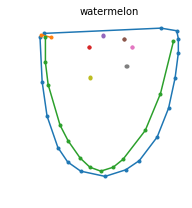

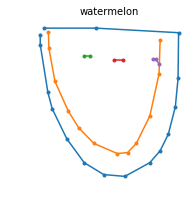

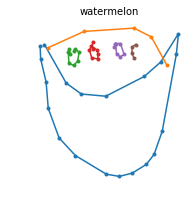

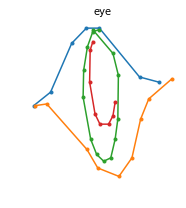

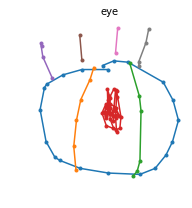

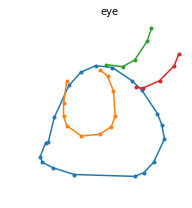

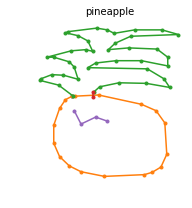

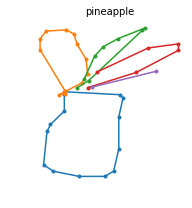

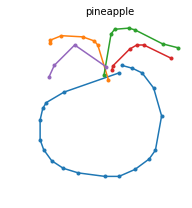

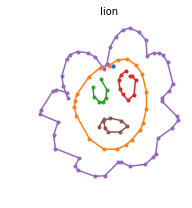

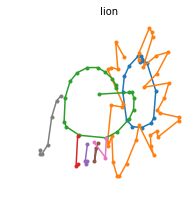

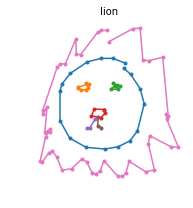

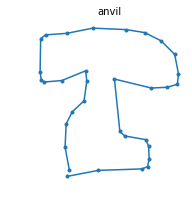

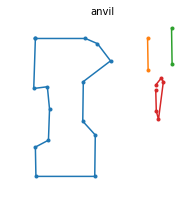

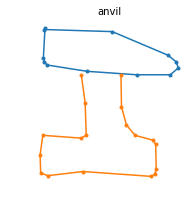

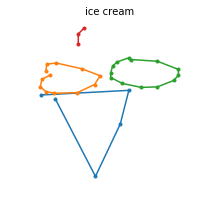

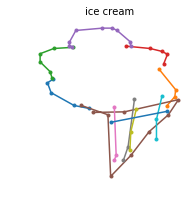

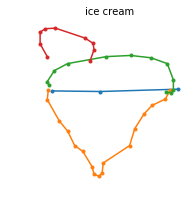

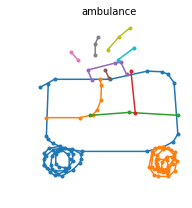

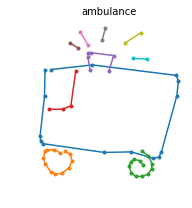

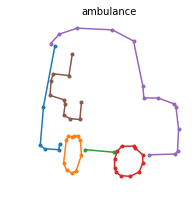

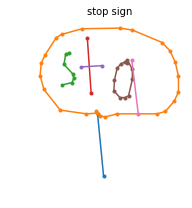

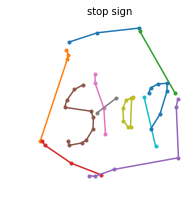

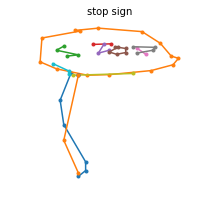

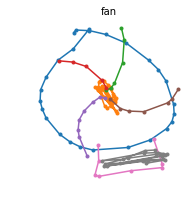

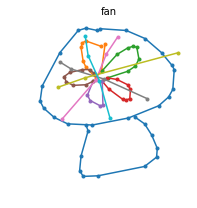

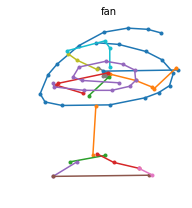

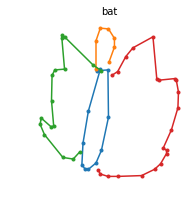

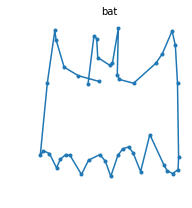

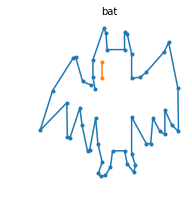

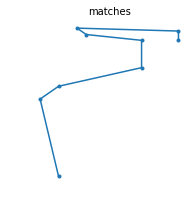

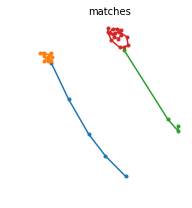

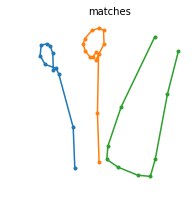

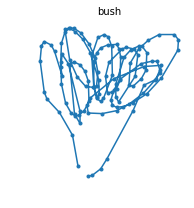

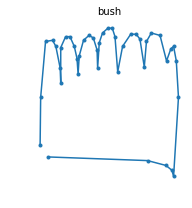

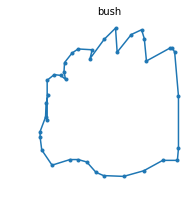

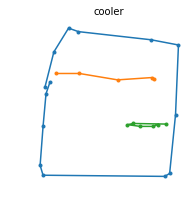

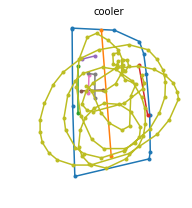

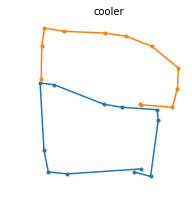

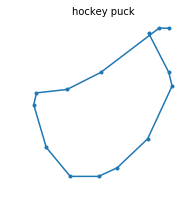

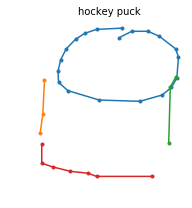

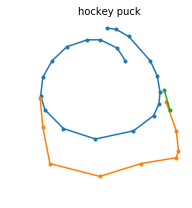

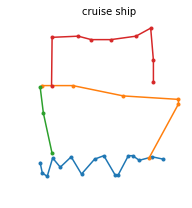

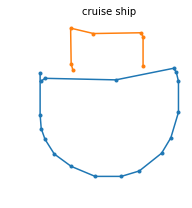

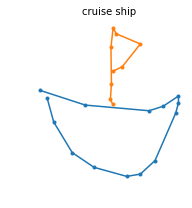

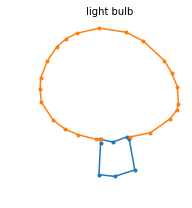

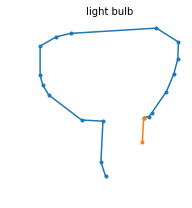

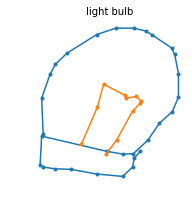

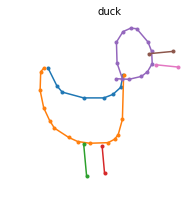

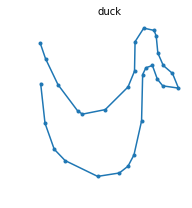

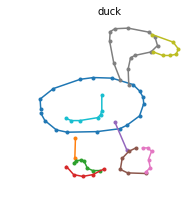

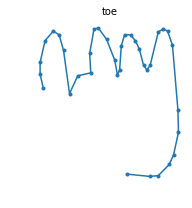

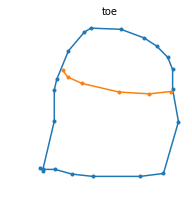

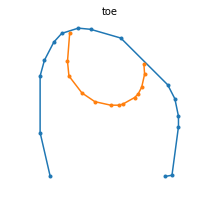

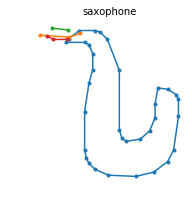

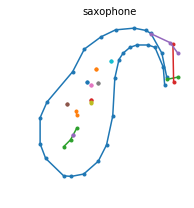

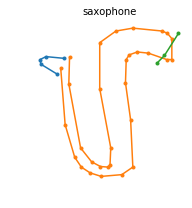

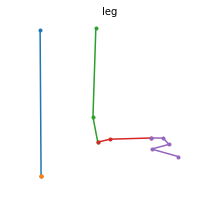

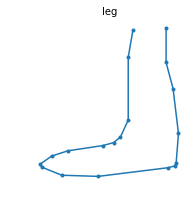

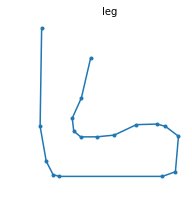

In [4]:
labels = draw_df.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)
    plt.gca().invert_yaxis()
    plt.show()

In [5]:
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(fnames)}
imheight, imwidth = 32, 32  
ims_per_class = 2000 

num_classes = len(fnames)
num_classes 

20

In [6]:
def strokesToNumpyArray(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255

def save_images(imagebag):
    #SAVE NUMPY ARRAY TO IMAGE
    from matplotlib import cm
    for image in range(len(imagebag.compute())):
        im = Image.fromarray(np.uint8(cm.gist_earth(imagebag.compute()[image])*255))
        #print(im)
        im.save("images/test{0}.png".format(image))

In [7]:
train_grand = []
class_paths = []
for f in fnames:
    class_paths.append("input/train_simplified/" + f)
for i,c in enumerate(class_paths[0: num_classes]):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(strokesToNumpyArray) 
    #save_images(imagebag)
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

In [8]:
train_grand.shape

(40000, 1025)

In [12]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(
    train_grand[ : , 1:], train_grand[ : , 0], test_size=0.2, random_state=42, shuffle=True)

y_train = keras.utils.to_categorical(Y_tr, num_classes)
X_train = X_tr.reshape(X_tr.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(Y_ts, num_classes)
X_val = X_ts.reshape(X_ts.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(32000, 20) 
 (32000, 32, 32, 1) 
 (8000, 20) 
 (8000, 32, 32, 1)


In [13]:
# Modify model layers to increase accuracy
# ------------------------------------------------
# Model 1
# ------------------------------------------------

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 680)               2785960   
__________

In [14]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()
callbacks = [history_cb]

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

In [ ]:
tf.global_variables_initializer()
model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 5,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 116s 4ms/step - loss: 1.3593 - acc: 0.5904 - top_3_accuracy: 0.7940 - val_loss: 0.7300 - val_acc: 0.7826 - val_top_3_accuracy: 0.9226
Epoch 2/5
32000/32000 [==============================] - 115s 4ms/step - loss: 0.7412 - acc: 0.7762 - top_3_accuracy: 0.9250 - val_loss: 0.6014 - val_acc: 0.8195 - val_top_3_accuracy: 0.9446
Epoch 3/5
32000/32000 [==============================] - 116s 4ms/step - loss: 0.5854 - acc: 0.8206 - top_3_accuracy: 0.9481 - val_loss: 0.5337 - val_acc: 0.8364 - val_top_3_accuracy: 0.9501
Epoch 4/5
32000/32000 [==============================] - 117s 4ms/step - loss: 0.4920 - acc: 0.8448 - top_3_accuracy: 0.9602 - val_loss: 0.4993 - val_acc: 0.8484 - val_top_3_accuracy: 0.9535
Epoch 5/5
14688/32000 [============>.................] - ETA: 1:00 - loss: 0.3898 - acc: 0.8781 - top_3_accuracy: 0.9728

In [ ]:
model.save('CNN-reLU-Test')
keras.metrics.top_3_accuracy = top_3_accuracy
model = keras.models.load_model('CNN-reLU-Test', custom_objects= {'metrics':['accuracy', top_3_accuracy]})

In [ ]:
mode21Hist = history_cb
print(len(mode21Hist.acc))
print(len(mode21Hist.val_acc))

In [ ]:
xVal = np.arange(1, 6, 1)
plt.plot(xVal, mode21Hist.acc)
plt.plot(xVal, mode21Hist.val_acc)
plt.title('Model 2 (with Batch Normalization)')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
#PREDICT BASED ON MODEL

ttvlist = []
reader = pd.read_csv('input/test_simplified.csv', index_col=['key_id'],
    chunksize=20)

for chunk in reader:
    drawing = [ast.literal_eval(pts) for pts in chunk.drawing.values]
    #labels = chunk.word.tolist()
    for i, example in enumerate(drawing):
        plt.figure(figsize=(6,3))
        for x,y in example:
            plt.subplot(1,2,1)
            plt.plot(x, y, marker='.')
            plt.axis('off')
            #label = labels[i]
            #plt.title(label, fontsize=10)
        plt.gca().invert_yaxis()
        plt.show()
    
    
    #CONVERT IMAGE TO NUMPY ARRAY
    imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    
    testarray = np.array(imagebag.compute())
    testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
    testpreds = model.predict(testarray, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
    ttvlist.append(ttvs)
    break

save_images(imagebag)
ttvarray = np.concatenate(ttvlist)